In [1]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras import datasets, layers, models
os.environ["CUDA_VISIBLE_DEVICES"]="3"

### Retrieve the images

In [2]:
import pathlib
train_data_dir = 'hhd_data/TRAIN'
train_data_dir = pathlib.Path(train_data_dir)
test_data_dir = 'hhd_data/TEST'
test_data_dir = pathlib.Path(test_data_dir)

In [3]:
train_image_count = len(list(train_data_dir.glob('*/*.png')))
train_image_count

3965

In [4]:
test_image_count = len(list(test_data_dir.glob('*/*.png')))
test_image_count

1134

In [5]:
CLASS_NAMES = np.array([item.name for item in test_data_dir.glob('*')])
CLASS_NAMES 

array(['23', '17', '22', '7', '15', '1', '4', '14', '19', '25', '8', '6',
       '2', '16', '26', '3', '11', '12', '13', '5', '9', '20', '18', '24',
       '0', '10', '21'], dtype='<U2')

In [6]:
NUMBER_OF_CLASSES = len(CLASS_NAMES)
BATCH_SIZE = 32
IMG_HEIGHT=70
IMG_WIDTH=70
TRAIN_STEPS_PER_EPOCH = np.ceil(train_image_count/BATCH_SIZE)
TEST_STEPS_PER_EPOCH = np.ceil(test_image_count/BATCH_SIZE)

### Visualisation functions

In [7]:
def show_logical_batch(image_batch, label_batch):
  plt.figure(figsize=(7,7))
  for n in range(9):
      ax = plt.subplot(3,3,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

In [8]:
def show_numerical_batch(image_batch, label_batch):
  plt.figure(figsize=(7,7))
  for n in range(9):
      ax = plt.subplot(3,3,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]])
      plt.axis('off')

### Load data

In [9]:
train_list_ds = tf.data.Dataset.list_files(str(train_data_dir/'*/*'))
test_list_ds = tf.data.Dataset.list_files(str(test_data_dir/'*/*'))

In [10]:
def get_logical_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

In [11]:
def get_numerical_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  numeric_label=tf.argmax(tf.cast((parts[-2] == CLASS_NAMES),dtype=tf.uint8))
  return numeric_label

In [12]:
def get_onehot_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  onehot_label=tf.cast((parts[-2] == CLASS_NAMES),dtype=tf.uint8)
  return onehot_label

In [13]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img,[IMG_HEIGHT,IMG_WIDTH])

In [14]:
def process_path(file_path):
  label = get_numerical_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [15]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_labeled_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_labeled_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [16]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [17]:
train_ds = prepare_for_training(train_labeled_ds)
test_ds = prepare_for_training(test_labeled_ds)
tf_image_batch, tf_label_batch= next(iter(train_ds))
#IMG_HEIGHT, IMG_WIDTH, _ =tf_image_batch[0].shape 

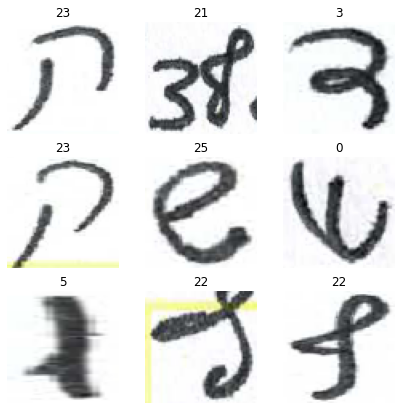

In [18]:
show_numerical_batch(tf_image_batch.numpy(), tf_label_batch.numpy())

### Model 1
#### Simple CNN model.

In [19]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(NUMBER_OF_CLASSES))

#### Compile and train the model

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_ds, epochs=100, 
                    validation_data=test_ds,
                    steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
                    validation_steps=TEST_STEPS_PER_EPOCH)

Train for 124.0 steps, validate for 36.0 steps
Epoch 1/100
124/124 [==============================] - 3s 27ms/step - loss: 2.4088 - accuracy: 0.3090 - val_loss: 1.6106 - val_accuracy: 0.5694
Epoch 2/100
124/124 [==============================] - 1s 8ms/step - loss: 1.3019 - accuracy: 0.6384 - val_loss: 1.2602 - val_accuracy: 0.6667
Epoch 3/100
124/124 [==============================] - 1s 7ms/step - loss: 0.9483 - accuracy: 0.7387 - val_loss: 1.1234 - val_accuracy: 0.6962
Epoch 4/100
124/124 [==============================] - 1s 7ms/step - loss: 0.7396 - accuracy: 0.8042 - val_loss: 1.1624 - val_accuracy: 0.6988
Epoch 5/100
124/124 [==============================] - 1s 8ms/step - loss: 0.5976 - accuracy: 0.8317 - val_loss: 1.2518 - val_accuracy: 0.7083
Epoch 6/100
124/124 [==============================] - 1s 7ms/step - loss: 0.4470 - accuracy: 0.8770 - val_loss: 1.2587 - val_accuracy: 0.7153
Epoch 7/100
124/124 [==============================] - 1s 8ms/step - loss: 0.3433 - accuracy: 

124/124 [==============================] - 1s 8ms/step - loss: 1.5949e-05 - accuracy: 1.0000 - val_loss: 4.2947 - val_accuracy: 0.7179
Epoch 58/100
124/124 [==============================] - 1s 8ms/step - loss: 1.4523e-05 - accuracy: 1.0000 - val_loss: 4.3132 - val_accuracy: 0.7170
Epoch 59/100
124/124 [==============================] - 1s 8ms/step - loss: 1.3125e-05 - accuracy: 1.0000 - val_loss: 4.3629 - val_accuracy: 0.7135
Epoch 60/100
124/124 [==============================] - 1s 8ms/step - loss: 1.2013e-05 - accuracy: 1.0000 - val_loss: 4.3987 - val_accuracy: 0.7153
Epoch 61/100
124/124 [==============================] - 1s 8ms/step - loss: 1.1488e-05 - accuracy: 1.0000 - val_loss: 4.4490 - val_accuracy: 0.7127
Epoch 62/100
124/124 [==============================] - 1s 8ms/step - loss: 1.0482e-05 - accuracy: 1.0000 - val_loss: 4.4012 - val_accuracy: 0.7161
Epoch 63/100
124/124 [==============================] - 1s 8ms/step - loss: 9.1796e-06 - accuracy: 1.0000 - val_loss: 4.4589 

#### Visualize the accuracy and loss plots

In [24]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()

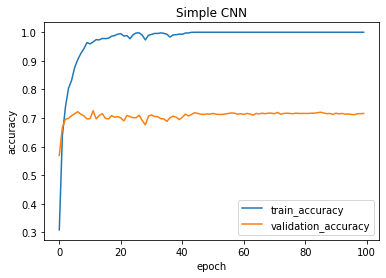

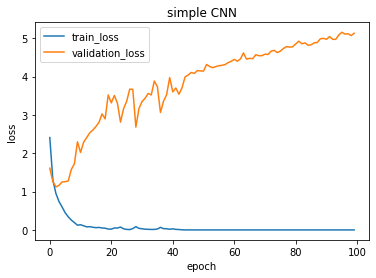

In [25]:
plot_accuracy(history,'Simple CNN')
plot_loss(history,'simple CNN')

#### Evaluate the model

In [26]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
test_images, test_labels=next(iter(test_ds))
predictions=probability_model.predict(test_images)

In [27]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} \n ({})".format(CLASS_NAMES[predicted_label],
                                CLASS_NAMES[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(NUMBER_OF_CLASSES))
  plt.yticks([])
  thisplot = plt.bar(range(NUMBER_OF_CLASSES), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

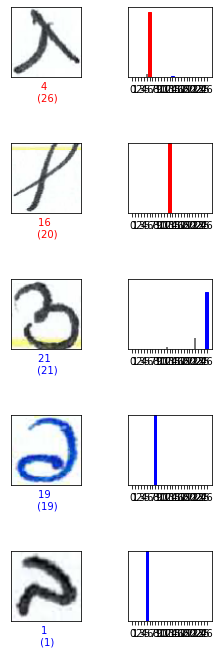

In [28]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 1
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout(pad=4.0)
plt.show()

### Model 2
#### AlexNet

In [29]:
model = tf.keras.models.Sequential([
    # 1st conv
  tf.keras.layers.Conv2D(96, (11,11),strides=(4,4), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, strides=(2,2)),
    # 2nd conv
  tf.keras.layers.Conv2D(256, (11,11),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
     # 3rd conv
  tf.keras.layers.Conv2D(384, (3,3),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
    # 4th conv
  tf.keras.layers.Conv2D(384, (3,3),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
    # 5th Conv
  tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, strides=(2, 2)),
  # To Flatten layer
  tf.keras.layers.Flatten(),
  # To FC layer 1
  tf.keras.layers.Dense(1024, activation='relu'),
    # add dropout 0.5 ==> tf.keras.layers.Dropout(0.5),
  #To FC layer 2
  tf.keras.layers.Dense(1024, activation='relu'),
    # add dropout 0.5 ==> tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(NUMBER_OF_CLASSES)
])

#### Compile and train the model

In [30]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_ds, epochs=100, 
                    validation_data=test_ds,
                    steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
                    validation_steps=TEST_STEPS_PER_EPOCH)

Train for 124.0 steps, validate for 36.0 steps
Epoch 1/100
124/124 [==============================] - 4s 34ms/step - loss: 2.4293 - accuracy: 0.3558 - val_loss: 6.6795 - val_accuracy: 0.0668
Epoch 2/100
124/124 [==============================] - 3s 20ms/step - loss: 1.2944 - accuracy: 0.6187 - val_loss: 2.5623 - val_accuracy: 0.3602
Epoch 3/100
124/124 [==============================] - 2s 20ms/step - loss: 0.9976 - accuracy: 0.7019 - val_loss: 3.1465 - val_accuracy: 0.3741
Epoch 4/100
124/124 [==============================] - 2s 20ms/step - loss: 0.8623 - accuracy: 0.7298 - val_loss: 1.9015 - val_accuracy: 0.5382
Epoch 5/100
124/124 [==============================] - 2s 20ms/step - loss: 0.7205 - accuracy: 0.7800 - val_loss: 2.2325 - val_accuracy: 0.5269
Epoch 6/100
124/124 [==============================] - 2s 20ms/step - loss: 0.6382 - accuracy: 0.7913 - val_loss: 1.1986 - val_accuracy: 0.7075
Epoch 7/100
124/124 [==============================] - 2s 20ms/step - loss: 0.5804 - accu

124/124 [==============================] - 2s 20ms/step - loss: 0.0653 - accuracy: 0.9806 - val_loss: 1.9522 - val_accuracy: 0.7752
Epoch 58/100
124/124 [==============================] - 2s 20ms/step - loss: 0.0547 - accuracy: 0.9839 - val_loss: 2.1404 - val_accuracy: 0.7214
Epoch 59/100
124/124 [==============================] - 2s 20ms/step - loss: 0.0886 - accuracy: 0.9753 - val_loss: 2.1108 - val_accuracy: 0.7691
Epoch 60/100
124/124 [==============================] - 2s 20ms/step - loss: 0.0954 - accuracy: 0.9738 - val_loss: 2.3570 - val_accuracy: 0.7483
Epoch 61/100
124/124 [==============================] - 2s 20ms/step - loss: 0.1215 - accuracy: 0.9698 - val_loss: 1.7871 - val_accuracy: 0.7405
Epoch 62/100
124/124 [==============================] - 2s 20ms/step - loss: 0.0536 - accuracy: 0.9849 - val_loss: 1.9119 - val_accuracy: 0.7648
Epoch 63/100
124/124 [==============================] - 2s 20ms/step - loss: 0.0448 - accuracy: 0.9899 - val_loss: 2.1112 - val_accuracy: 0.750

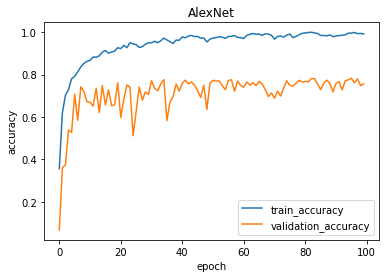

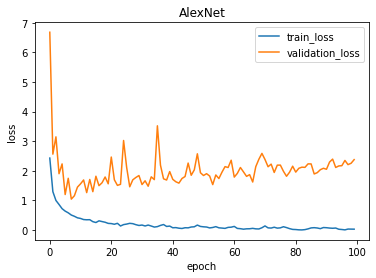

In [31]:
plot_accuracy(history,'AlexNet')
plot_loss(history,'AlexNet')

#### Evaluate the model

In [32]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
#test_images, test_labels=next(iter(test_ds))
predictions=probability_model.predict(test_images)

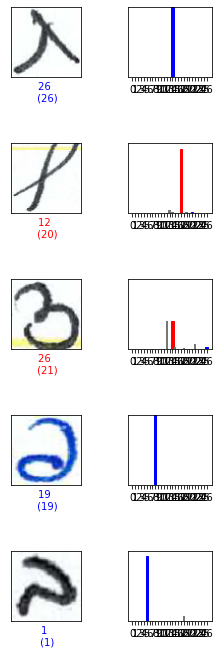

In [33]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 1
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout(pad=4.0)
plt.show()

### Model 3
#### ResNet

In [34]:
base_model = tf.keras.applications.ResNet50(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                               include_top=False,
                                               weights='imagenet')

In [35]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(NUMBER_OF_CLASSES)
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

#### Compile and train the model

In [36]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_ds, epochs=100, 
                    validation_data=test_ds,
                    steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
                    validation_steps=TEST_STEPS_PER_EPOCH)

Train for 124.0 steps, validate for 36.0 steps
Epoch 1/100
124/124 [==============================] - 17s 136ms/step - loss: 1.3943 - accuracy: 0.6439 - val_loss: 5.7835 - val_accuracy: 0.0391
Epoch 2/100
124/124 [==============================] - 9s 72ms/step - loss: 0.6706 - accuracy: 0.8191 - val_loss: 4.0009 - val_accuracy: 0.0399
Epoch 3/100
124/124 [==============================] - 9s 72ms/step - loss: 0.4745 - accuracy: 0.8674 - val_loss: 3.6566 - val_accuracy: 0.0460
Epoch 4/100
124/124 [==============================] - 9s 72ms/step - loss: 0.3807 - accuracy: 0.8868 - val_loss: 4.4150 - val_accuracy: 0.0269
Epoch 5/100
124/124 [==============================] - 9s 72ms/step - loss: 0.3001 - accuracy: 0.9105 - val_loss: 3.1284 - val_accuracy: 0.2257
Epoch 6/100
124/124 [==============================] - 9s 72ms/step - loss: 0.2566 - accuracy: 0.9239 - val_loss: 1.6161 - val_accuracy: 0.5122
Epoch 7/100
124/124 [==============================] - 9s 72ms/step - loss: 0.2149 - ac

124/124 [==============================] - 9s 75ms/step - loss: 1.3058e-04 - accuracy: 1.0000 - val_loss: 1.1811 - val_accuracy: 0.8411
Epoch 58/100
124/124 [==============================] - 9s 74ms/step - loss: 8.4080e-05 - accuracy: 1.0000 - val_loss: 1.1772 - val_accuracy: 0.8455
Epoch 59/100
124/124 [==============================] - 9s 75ms/step - loss: 7.5203e-05 - accuracy: 1.0000 - val_loss: 1.2335 - val_accuracy: 0.8403
Epoch 60/100
124/124 [==============================] - 9s 75ms/step - loss: 6.0201e-05 - accuracy: 1.0000 - val_loss: 1.1923 - val_accuracy: 0.8438
Epoch 61/100
124/124 [==============================] - 9s 75ms/step - loss: 6.2220e-05 - accuracy: 1.0000 - val_loss: 1.2456 - val_accuracy: 0.8394
Epoch 62/100
124/124 [==============================] - 9s 75ms/step - loss: 5.9322e-05 - accuracy: 1.0000 - val_loss: 1.2390 - val_accuracy: 0.8420
Epoch 63/100
124/124 [==============================] - 9s 76ms/step - loss: 5.7354e-05 - accuracy: 1.0000 - val_loss: 

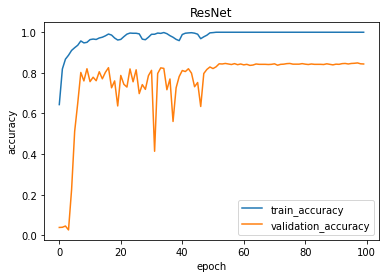

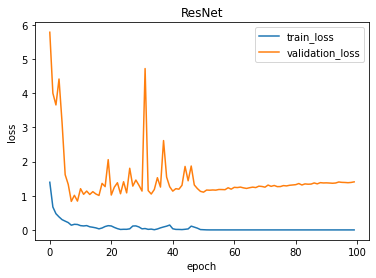

In [37]:
plot_accuracy(history,'ResNet')
plot_loss(history,'ResNet')

#### Evaluate the model

In [38]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
test_images, test_labels=next(iter(test_ds))
predictions=probability_model.predict(test_images)

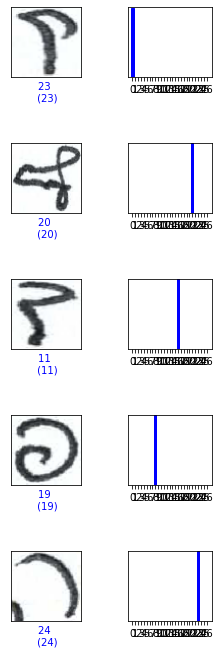

In [39]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 1
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout(pad=4.0)
plt.show()